In [26]:
import re
import sys
import time
import nltk
import random
import pprint
import logging
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
import gensim, spacy, logging, warnings
import gensim.utils
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models
from gensim.corpora import MmCorpus
from gensim.models import Word2Vec
from gensim.models import CoherenceModel

import scipy.stats as stats
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.snowball import SnowballStemmer

Loading BokehJS ...

In [28]:
df = pd.read_csv("case.csv", encoding='latin1')
df

,No,Judge,Subject,Date,Judgement
0,1,Justice Gulzar Ahmed,Land acquisition,22-Sep-21,There is a big issue for the Government of Sin...
1,2,Justice Gulzar Ahmed,Service,24-Mar-21,"The petitioner-Getz Pharma (Pvt.) Limited, has..."
2,3,Justice Gulzar Ahmed,Service,8-Jun-21,Facts of the matter are that the respondent wa...
3,4,Justice Qazi Faez Isa,harrasement,20-Aug-21,An application has been submitted in Court by ...
4,5,Justice Maqbool Baqar,Land acquisition,19-Feb-20,"A property bearing House No.861, Akbari Gate, ..."
5,6,Justice Maqbool Baqar,Tax/Excise Duty,22-Jan-20,The question involved in the instant petitions...
6,7,Justice Maqbool Baqar,Service,16-Feb-16,In response to an advertisement placed by the ...
7,8,Justice Ejaz Afzal Khan,Death Sentence,12-May-16,This appeal with the leave of the Court has ar...
8,9,Justice Ejaz Afzal Khan,Exit Control List,13-Apr-16,These petitions for leave to appeal have arise...
9,10,Justice Ejaz Afzal Khan,Compensation on death,11-May-18,"We have been informed that on 17.12.2017, a su..."


In [29]:
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [30]:
remove_words = ['newss','dataset','datasets']

In [31]:
stoplist = set('for a of the and to in'.split())

In [32]:
text = df.Judgement.values

In [33]:
text

array(['There is a big issue for the Government of Sindh so also the Government of Pakistan to rehabilitate the affectees of the Gujjar Nalah, Orangi Nalah and Mehmoodabad Nalah, in that, the Government of Sindh says that it has no funds altogether to provide for the rehabilitation of the affectees. The statement of the Advocate General Sindh on its face appears to be not reasonable rather such a statement ought not to have been made by the Advocate General Sindh before this Court rather the Sindh Government ought to have stated that as it had stated before this Court which is reflected in the previous orders of this Court, it will do everything to provide for the rehabilitation of the affectees of the above Nalahs. Funding for such rehabilitation is the responsibility of the Government of Sindh itself, in that, as a Government, it has to provide funding from its available resources and the Sindh Government cannot be obliviated of its responsibility. We, therefore, direct the Chief Min

In [34]:
wordcloud = WordCloud(
    width = 2500,
    height = 1500,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))

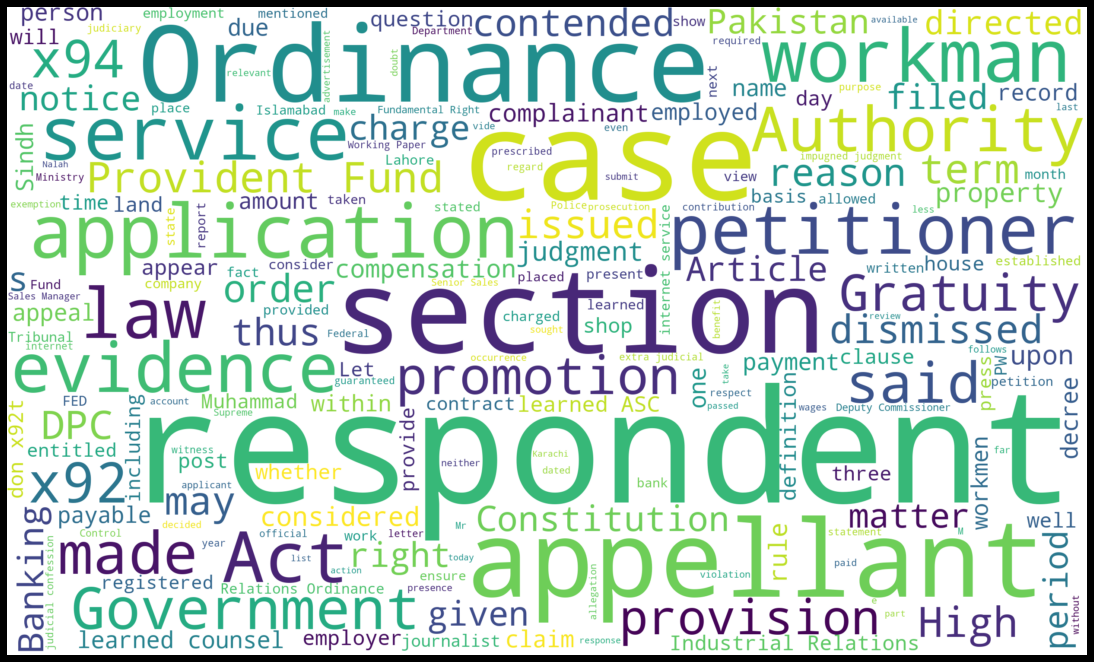

In [38]:
fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [39]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [40]:
texts = []

for i in df['Judgement'].iteritems():
    raw = str(i[1]).lower()
    tokens = tokenizer.tokenize(raw)

    stopped_tokens = [raw for raw in tokens if not raw in en_stop]
    
    stopped_tokens_new = [raw for raw in stopped_tokens if not raw in remove_words]
    
    lemma_tokens = [lemmatizer.lemmatize(tokens) for tokens in stopped_tokens_new]
    
    new_lemma_tokens = [raw for raw in lemma_tokens if not len(raw) == 1]
    
    texts.append(new_lemma_tokens)

print(texts[0])

['big', 'issue', 'government', 'sindh', 'also', 'government', 'pakistan', 'rehabilitate', 'affectees', 'gujjar', 'nalah', 'orangi', 'nalah', 'mehmoodabad', 'nalah', 'government', 'sindh', 'say', 'fund', 'altogether', 'provide', 'rehabilitation', 'affectees', 'statement', 'advocate', 'general', 'sindh', 'face', 'appears', 'reasonable', 'rather', 'statement', 'ought', 'made', 'advocate', 'general', 'sindh', 'rather', 'sindh', 'government', 'ought', 'stated', 'stated', 'reflected', 'previous', 'order', 'everything', 'provide', 'rehabilitation', 'affectees', 'nalahs', 'funding', 'rehabilitation', 'responsibility', 'government', 'sindh', 'government', 'provide', 'funding', 'available', 'resource', 'sindh', 'government', 'cannot', 'obliviated', 'responsibility', 'therefore', 'direct', 'chief', 'minister', 'government', 'sindh', 'ensure', 'affectees', 'nalahs', 'rehabilitated', 'providing', 'sort', 'amenity', 'required', 'present', 'day', 'living', 'chief', 'minister', 'government', 'sindh', 

In [41]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(dictionary)

Dictionary(1993 unique tokens: ['abdul', 'abro', 'achieved', 'acquiring', 'action']...)


In [42]:
#LDA Model
import pprint
from gensim.models.ldamodel import LdaModel

lda = LdaModel(corpus, id2word=dictionary, num_topics=4, update_every=1, chunksize=10000, random_state=100, passes=20)

pprint.pprint(lda.top_topics(corpus,topn=4))

[([(0.029905133, 'promotion'),
   (0.018421981, 'dpc'),
   (0.01747475, 'respondent'),
   (0.01364284, 'case')],
  8.541648869648461e-12),
 ([(0.013319836, 'evidence'),
   (0.012519178, 'appellant'),
   (0.0111889, 'case'),
   (0.0084818425, 'could')],
  -0.17497035407787487),
 ([(0.015160108, 'service'),
   (0.012272809, 'also'),
   (0.0105392, 'internet'),
   (0.0099607585, 'pakistan')],
  -0.7148481064957131),
 ([(0.02196176, 'respondent'),
   (0.01582083, 'ordinance'),
   (0.015049465, 'workman'),
   (0.012815278, 'section')],
  -0.7714811187611234)]


In [43]:
from pprint import pprint
pprint(lda.print_topics())
doc_lda = lda[corpus]

[(0,
  '0.013*"evidence" + 0.013*"appellant" + 0.011*"case" + 0.008*"could" + '
  '0.007*"compensation" + 0.006*"learned" + 0.006*"complainant" + 0.005*"asc" '
  '+ 0.005*"shop" + 0.005*"muhammad"'),
 (1,
  '0.030*"promotion" + 0.018*"dpc" + 0.017*"respondent" + 0.014*"case" + '
  '0.011*"post" + 0.009*"service" + 0.009*"consider" + 0.008*"department" + '
  '0.008*"working" + 0.008*"grant"'),
 (2,
  '0.015*"service" + 0.012*"also" + 0.011*"internet" + 0.010*"pakistan" + '
  '0.009*"press" + 0.008*"issued" + 0.008*"application" + 0.008*"right" + '
  '0.008*"constitution" + 0.006*"charge"'),
 (3,
  '0.022*"respondent" + 0.016*"ordinance" + 0.015*"workman" + 0.013*"section" '
  '+ 0.009*"authority" + 0.008*"fund" + 0.008*"petitioner" + 0.007*"law" + '
  '0.007*"judgment" + 0.007*"case"')]


In [44]:
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=corpora.Dictionary(texts), coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nLDA Coherence Score: ', coherence_lda)    


LDA Coherence Score:  0.4441493278537401


In [19]:
#LSA Model
import pprint
from gensim.models import LsiModel
 
NUM_TOPICS = 4

lsa = LsiModel(corpus, id2word=dictionary, chunksize=10000, num_topics=NUM_TOPICS)

lsa_topics = lsa.show_topics(num_topics=NUM_TOPICS, formatted=False)

pprint.pprint(lsa_topics)

[(0,
  [('respondent', 0.4210535399124781),
   ('workman', 0.34862735554559104),
   ('ordinance', 0.26933314875425984),
   ('section', 0.19556853958188675),
   ('petitioner', 0.17699020581423172),
   ('authority', 0.17513680002171206),
   ('fund', 0.16889105947425223),
   ('case', 0.1659888531129707),
   ('service', 0.15873868881391043),
   ('provident', 0.1503882710196667)]),
 (1,
  [('evidence', -0.3833951452609768),
   ('appellant', -0.3745526199531057),
   ('case', -0.18805580861587767),
   ('complainant', -0.17870791661264748),
   ('could', -0.15923049071902948),
   ('shop', -0.1429663332901176),
   ('confession', -0.13105247218260802),
   ('muhammad', -0.12997407590766832),
   ('workman', 0.12446895890729558),
   ('thus', -0.10750594996627218)]),
 (2,
  [('government', 0.22714872944467915),
   ('promotion', 0.22648784582752204),
   ('also', 0.21634954042847152),
   ('press', 0.19003429624833337),
   ('pakistan', 0.18289081419701417),
   ('workman', -0.16685006732694702),
   ('con

In [45]:
from pprint import pprint
pprint(lsa.print_topics())
doc_lsa = lsa[corpus]

[(0,
  '0.421*"respondent" + 0.349*"workman" + 0.269*"ordinance" + 0.196*"section" '
  '+ 0.177*"petitioner" + 0.175*"authority" + 0.169*"fund" + 0.166*"case" + '
  '0.159*"service" + 0.150*"provident"'),
 (1,
  '-0.383*"evidence" + -0.375*"appellant" + -0.188*"case" + '
  '-0.179*"complainant" + -0.159*"could" + -0.143*"shop" + -0.131*"confession" '
  '+ -0.130*"muhammad" + 0.124*"workman" + -0.108*"thus"'),
 (2,
  '0.227*"government" + 0.226*"promotion" + 0.216*"also" + 0.190*"press" + '
  '0.183*"pakistan" + -0.167*"workman" + 0.166*"constitution" + 0.166*"issued" '
  '+ -0.161*"evidence" + 0.154*"right"'),
 (3,
  '-0.471*"promotion" + -0.289*"dpc" + -0.209*"respondent" + -0.168*"post" + '
  '0.159*"pakistan" + 0.151*"press" + -0.146*"service" + 0.145*"also" + '
  '-0.135*"consider" + -0.123*"case"')]


In [46]:
coherence_model_lsa = CoherenceModel(model=lsa, texts=texts, dictionary=corpora.Dictionary(texts), coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nLSA Coherence Score: ', coherence_lsa)


LSA Coherence Score:  0.5599290538278823


In [47]:
#HDP Model
from gensim.models.hdpmodel import HdpModel

hdp = HdpModel(corpus, id2word=dictionary)

hdp_topics = hdp.print_topics(4)
for topic in hdp_topics:
  print(topic)

(0, '0.028*respondent + 0.026*workman + 0.018*ordinance + 0.013*petitioner + 0.013*authority + 0.012*fund + 0.012*section + 0.011*gratuity + 0.011*provident + 0.010*service')
(1, '0.019*evidence + 0.018*appellant + 0.009*complainant + 0.009*case + 0.008*could + 0.007*shop + 0.007*confession + 0.007*muhammad + 0.005*thus + 0.005*pw')
(2, '0.014*press + 0.013*pakistan + 0.013*also + 0.011*constitution + 0.010*right + 0.010*issued + 0.009*journalist + 0.009*islamabad + 0.008*article + 0.008*fundamental')
(3, '0.015*government + 0.013*sindh + 0.013*land + 0.012*commissioner + 0.009*karachi + 0.009*also + 0.008*shall + 0.006*jacobabad + 0.006*deputy + 0.006*plot')


In [48]:
hdp_cm=CoherenceModel(model=hdp,dictionary=dictionary,texts= texts,coherence='c_v')
coherence_hdp=hdp_cm.get_coherence()
print('\nHDP Coherence Score: ', coherence_hdp)


HDP Coherence Score:  0.7340099648523796


In [49]:
coherence = {'LDA':coherence_lda,'LSA':coherence_lsa,'HDP':coherence_hdp}

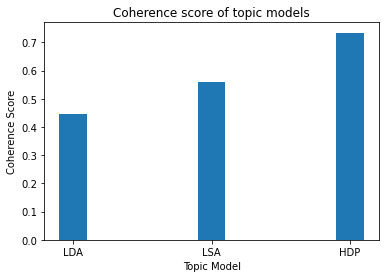

In [50]:
import matplotlib.pyplot as plt
coherence_value = list(coherence.values())
model_name = list(coherence.keys())
plt.bar(range(len(model_name)),coherence_value, width=0.2, align='center', tick_label=model_name)
plt.title('Coherence score of topic models')
plt.xlabel('Topic Model')
plt.ylabel('Coherence Score')
plt.show()